In [3]:
import numpy as np
import matplotlib.pyplot as plt

In tempo continuo: $\frac{dS}{dt} = - \frac{\beta I S}{N}$ 

In tempo discreto: $\frac{∆S}{∆t} = - \frac{\beta I S}{N}∆t$

Quindi lo stato $S(t)$ varia secondo la legge $S(t+∆t) = S(t) - \frac{\beta I S}{N}∆t$

oppure con $∆t = 1$, $S(t+1) = S(t) - \frac{\beta I S}{N}$

In [15]:
class model_epi():
    def __init__(self):
        self.S = 50000
        self.I = 100
        self.R = 0
        self.N = self.S + self.I + self.R
        self.T = 1000
        self.beta = 0.2
        self.gamma = 0.1

        self.S_ts = []
        self.I_ts = []
        self.R_ts = []

    def run(self):

        for t in range(self.T):

            new_I = self.beta * self.S * self.I / self.N
            new_R = self.I * self.gamma
            self.S = self.S - new_I
            self.I = self.I + new_I - new_R
            self.R = self.R + new_R

            self.S_ts.append(self.S)
            self.I_ts.append(self.I)
            self.R_ts.append(self.R)

    def run_one_step(self, pm):

        print_bool = False

        beta = self.beta * (1 - (pm.beta_red * pm.my_action))
        if print_bool: print('beta', beta)
        new_I = beta * self.S * self.I / self.N
        if print_bool: print('new i', new_I)
        new_R = self.I * self.gamma
        self.S = self.S - new_I
        self.I = self.I + new_I - new_R
        self.R = self.R + new_R

        self.S_ts.append(self.S)
        self.I_ts.append(self.I)
        self.R_ts.append(self.R)
        return new_I
    
    def plot_ts(self):
        plt.plot(self.S_ts, label = 'susceptible')
        plt.plot(self.I_ts, label = 'infected')
        plt.plot(self.R_ts, label = 'recovered')
        plt.legend()
        plt.show()


    def plot_ts_2(self, I_star):
        plt.plot(self.I_ts, label = 'infected')
        plt.plot([I_star for t in range(len(self.I_ts))], label = "I*")
        plt.legend()
        plt.show()


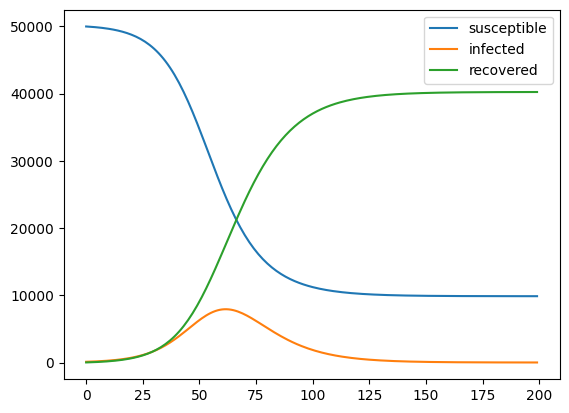

In [5]:
model = model_epi()
model.run()
model.plot_ts()

Il policy maker si addestra su molteplici iterazioni del modello. Quindi, per una istanza di pm farò andare N volte il modello epidemiologico. 

Le azioni sono due (chiudo o non chiudo), che hanno effetto su beta (il tasso di contagio), e gli stati del sistema sono due (infeetti sopra o sotto la soglia $I^*$).

In [16]:
class pm:
    def __init__(self):
        self.q_table = np.zeros([2,2])
        self.explor_rate = 0.01
        self.update_rate = 0.2
        self.epochs = 100

        self.I_star = 2000
        self.beta_red = 0.2 # reduction of beta

        self.my_action = None
        self.score_per_I = -1
        self.score_per_ld = -1000

        self.cost_I = 0
        self.cost_ld = 0
        self.results = []
        self.results_Day = []
        self.results_Day_Max = []

    def action(self, model):

        print_bool = False
        
        for t in range(model.T):
            state = 0 if model.I < self.I_star else 1
            if np.random.random() < self.explor_rate:
                self.my_action = np.random.randint(0,2)
                if print_bool: print(state, self.my_action, 'Mode1', model.I)
            else:
                self.my_action = np.argmax(self.q_table[state])
                if print_bool: print(state, self.my_action, 'Mode2', model.I)
            
            
            
            new_I = model.run_one_step(self)
            self.cost_I += new_I * self.score_per_I
            self.cost_ld += self.my_action * self.score_per_ld
            new_cost = (new_I * self.score_per_I) + (self.my_action * self.score_per_ld)
            if print_bool: print("new cost", new_cost)
            if print_bool: print(t, model.T)
            
            if print_bool: print(self.my_action, new_I, new_cost * self.update_rate)
            if print_bool: print(self.q_table[state, self.my_action] * (1 - self.update_rate), (new_cost * self.update_rate))
            if self.q_table[state, self.my_action] == 0:
                self.q_table[state, self.my_action] = new_cost
            else:
                self.q_table[state, self.my_action] = self.q_table[state, self.my_action] * (1 - self.update_rate) + (new_cost * self.update_rate)
            if print_bool: print(self.q_table)

            self.results_Day.append(new_cost)

            self.results_Day_Max.append(max(self.results_Day))

    def training(self): # Gli infetti si riducono con il tempo, non dichiarando il modello nel ciclo si riducono anche senza pm
        
        for epoch in range(self.epochs):
            model = model_epi()
            self.action(model)
            result_epoch = self.cost_I + self.cost_ld
            #print("result", result_epoch)
            self.results.append(result_epoch)
            self.cost_I, self.cost_ld = 0,0
    
        return model

    def plot_results(self):
        plt.plot(self.results)
        plt.title('score per epoch')
        plt.xlabel('epoch')
        plt.ylabel('score')
        plt.show()
        
        print(self.q_table)

    def plot_results_day(self):
        plt.plot(self.results_Day)
        plt.title('score per day')
        plt.xlabel('day')
        plt.ylabel('score')
        plt.show()
        
        print(self.q_table)
    
    def plot_results_day_Max(self):
        plt.plot(self.results_Day_Max)
        plt.title('score per day max')
        plt.xlabel('day')
        plt.ylabel('score')
        plt.show()
        
        print(self.q_table)

In [18]:
my_pm = pm()
my_pm.epochs = 700
last_mod = my_pm.training()
my_pm.plot_results()
#my_pm.plot_results_day()
my_pm.plot_results_day_Max()
last_mod.plot_ts_2(my_pm.I_star)





KeyboardInterrupt: 